<a href="https://colab.research.google.com/github/devansurf/Carlini-WagnerL2/blob/main/Carlini%26Wagner_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carlini & Wagner (L2) Adversarial Attack
Load pretrained models from HuggingFace, run attacks and plot images and any relevant metrics

In [1]:
%pip install torchattacks

In [2]:
%pip install accelerate -U

IMPORTS!!!

In [3]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from transformers import TrainingArguments, Trainer, default_data_collator
from transformers import ViTImageProcessor, BeitImageProcessor, ConvNextImageProcessor
from transformers import ViTForImageClassification, AutoModelForImageClassification
from transformers import ViTFeatureExtractor, BeitFeatureExtractor, ConvNextFeatureExtractor

from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from torch import nn

In [4]:
# CPU or GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [5]:
#Confusion matrix
def generate_confusion_matrix(actual_labels, predicted_labels, classes):
    cm = confusion_matrix(actual_labels, predicted_labels)


    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g")
    ax.set_xlabel("Predicted", fontsize=20)
    ax.xaxis.set_label_position("bottom")
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel("True", fontsize=20)
    plt.yticks(rotation=0)

    plt.title("Confusion Matrix", fontsize=20)

    plt.show()

    F1_score = f1_score(actual_labels, predicted_labels, average='macro')

    print(f'f1_score: {F1_score}')

In [6]:
def plot_images(x, y, class_names, x_adv=None, y_adv=None):
    if x_adv is not None:
        fig, ax = plt.subplots(3, 10, figsize=(20, 5))
    else:
        fig, ax = plt.subplots(1, 10, figsize=(20, 5))

    for i in range(10):
        if x_adv is not None:
            ax[0, i].imshow(x[i].permute(1, 2, 0))
            ax[0, i].set_title(class_names[y[i]])
            ax[0, i].axis("off")
            ax[1, i].imshow(x_adv[i].detach().cpu().permute(1, 2, 0))
            if y_adv[i].item() != y[i].item():
                ax[1, i].set_title(class_names[y_adv[i]], color="r")
            else:
                ax[1, i].set_title(class_names[y_adv[i]], color="k")
            ax[1, i].axis("off")
            ax[2, i].imshow(
                (torch.abs(x[i] - x_adv[i].detach().cpu()) * 25)
                .clamp_(0, 1)
                .permute(1, 2, 0)
            )
            ax[2, i].axis("off")
        else:
            ax[i].imshow(x[i].permute(1, 2, 0))
            ax[i].set_title(class_names[y[i]])
            ax[i].axis("off")

In [7]:
class HuggingFaceModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingFaceModelWrapper, self).__init__()
        # Load the pretrained model

        self.model = model
        #Hardcoded output layer (That of CIFAR10 num_classes)
        #self.model.classifier = nn.Linear(self.model.classifier.in_features, 10)

    def forward(self, pixel_values):
        if not isinstance(pixel_values, torch.Tensor):
            raise ValueError("pixel_values must be a torch.Tensor")

        # Hugging Face models expect a dictionary with 'pixel_values' as the key
        outputs = self.model(pixel_values=pixel_values)

        # Extract logits
        logits = outputs.logits

        return logits

HuggingFace pretrained models

In [8]:
# ViT model
model_name_vit = "google/vit-base-patch16-224-in21k"
feature_extractor_vit = ViTFeatureExtractor.from_pretrained(model_name_vit)
model_vit = ViTForImageClassification.from_pretrained(model_name_vit, num_labels=10)

# BEiT model
model_name_beit = "microsoft/beit-base-patch16-224-pt22k-ft22k"
feature_extractor_beit = BeitFeatureExtractor.from_pretrained(model_name_beit)
model_beit = AutoModelForImageClassification.from_pretrained(model_name_beit)

# ConvNeXt model
model_name_convnext = "facebook/convnext-base-224"
feature_extractor_convnext = ConvNextFeatureExtractor.from_pretrained(model_name_convnext)
model_convnext = AutoModelForImageClassification.from_pretrained(model_name_convnext)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

HuggingFace Wrapper function to handle outputs for torchattacks

In [9]:
class CIFAR10HuggingFace(Dataset):
    def __init__(self, split='train', subset_size=1000):
        self.split = split
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)), #model input size
            transforms.ToTensor(),
        ])

         # Load the full dataset
        self.dataset = datasets.CIFAR10(root='./data', train=(split == 'train'),
                                        download=True, transform=self.transform)
        self.classes = self.dataset.classes

        if (split == 'train'):
            # Generate a random subset of indices
            if subset_size > len(self.dataset):
                raise ValueError("Subset size is larger than the dataset size.")
            subset_indices = np.random.choice(len(self.dataset), subset_size, replace=False)

            # Create a dataset subset
            self.dataset = Subset(self.dataset, subset_indices)



    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {'pixel_values': image, 'labels': label}


In [10]:
#Fine-Tune model
train_dataset = CIFAR10HuggingFace(split='train', subset_size=10000)
eval_dataset = CIFAR10HuggingFace(split='test')

def train_model(model, feature_extractor):
    model = model.to(device)
    training_args = TrainingArguments(
        output_dir='./results',          # Where to store the model checkpoints
        num_train_epochs=3,              # Number of training epochs
        per_device_train_batch_size=16,   # Training batch size
        per_device_eval_batch_size=16,    # Evaluation batch size
        warmup_steps=500,                # Number of warmup steps
        weight_decay=0.01,               # Weight decay
        logging_dir='./logs',            # Where to store logs
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator, #not usually used in Image Processing, but used mostly in NLP's
        tokenizer=feature_extractor,
    )
    trainer.train()
    trainer.evaluate()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
#Train all models
train_model(model_vit, feature_extractor_vit)
model_vit = HuggingFaceModelWrapper(model_vit)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,2.320600
20,2.308900
30,2.313600
40,2.304500
50,2.289300
60,2.275900
70,2.254400
80,2.241800
90,2.219200
100,2.176600


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [12]:
#probably want to gather checkpoints and load them here


Lets start making some predictions

In [17]:
def run_attack(model):
    carlini_wagner_attack= torchattacks.CW(model.to(device), c=1, steps=1000, lr=0.01)

    test_dataset = datasets.CIFAR10(root='./data', train=False,
        download=True, transform=transforms.Compose([
            transforms.Resize((224, 224)), #model input size
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize using CIFAR10 norm values
        ]))

    CIFAR10_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for image, label in CIFAR10_dataloader:
        image, label = image.to(device), label.to(device)

        #make prediction without using adversarial images
        # inputs = feature_extractor_vit(images=image, return_tensors="pt")
        # inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            predictions = model(image)
        predicted_label = torch.argmax(predictions, dim=1)

        plot_images(image.cpu(), predicted_label.cpu(), test_dataset.classes)
        generate_confusion_matrix(predicted_label.cpu(), label.cpu(), test_dataset.classes)

        # Create adversarial images
        adv_image = carlini_wagner_attack(image,label)

        # Now process images through the feature extractor
        # inputs_adv = feature_extractor_vit(images=adv_images, return_tensors="pt")
        # inputs_adv = {k: v.to(device) for k, v in inputs_adv.items()}

        # Make predictions using adversarial images
        with torch.no_grad():
            predictions = model(adv_image)
        adv_label = torch.argmax(predictions, dim=1)

        # print(len(image))
        # print(len(label))
        # print(CIFAR10_classes)
        # print(len(adv_image))
        # print(len(adv_label))
        #plot the results
        plot_images(image.cpu(), label.cpu(), test_dataset.classes, x_adv=adv_image.cpu(), y_adv=adv_label.cpu())
        generate_confusion_matrix(adv_label.cpu(), label.cpu(), test_dataset.classes)

        break

Files already downloaded and verified


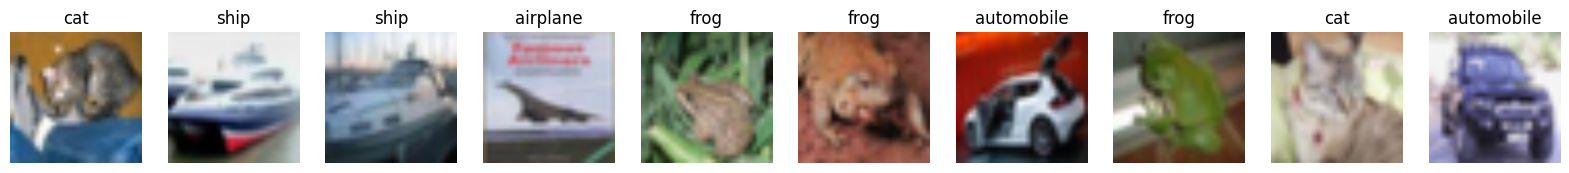

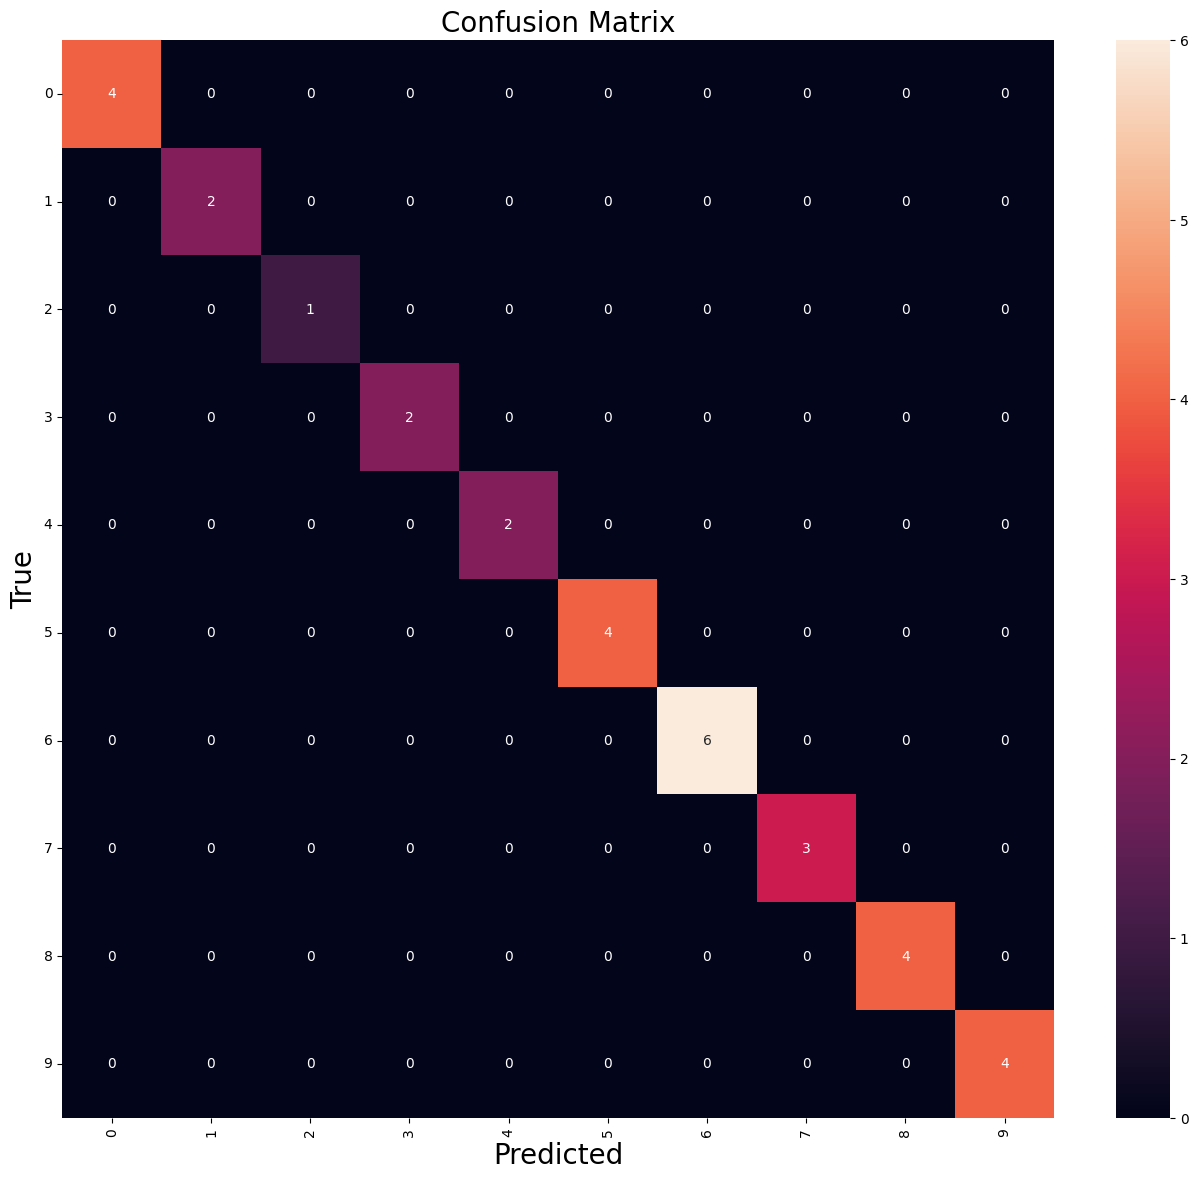

f1_score: 1.0


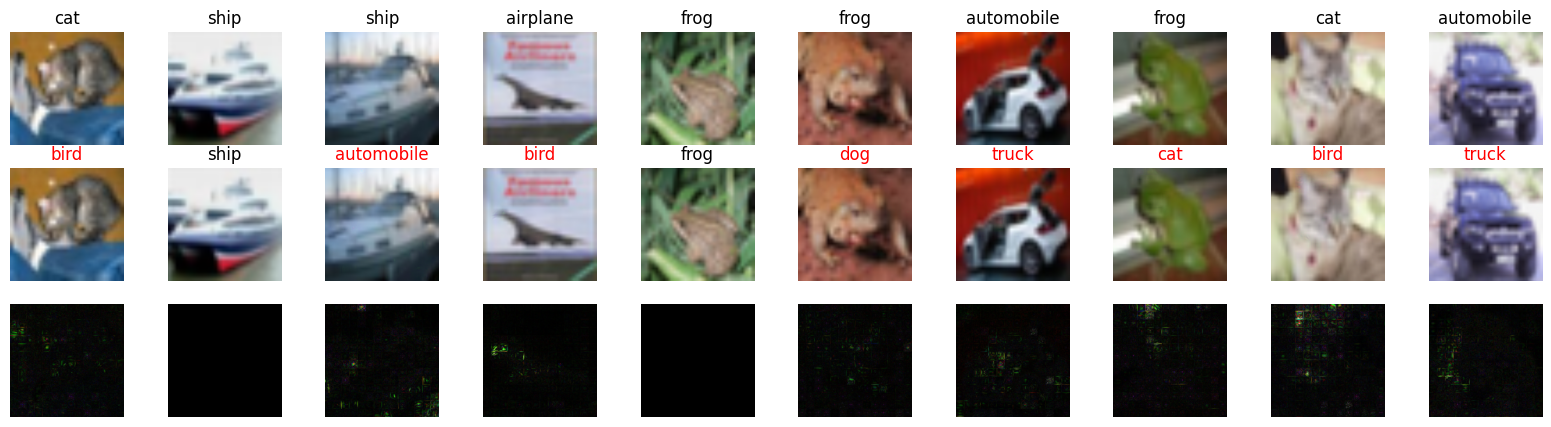

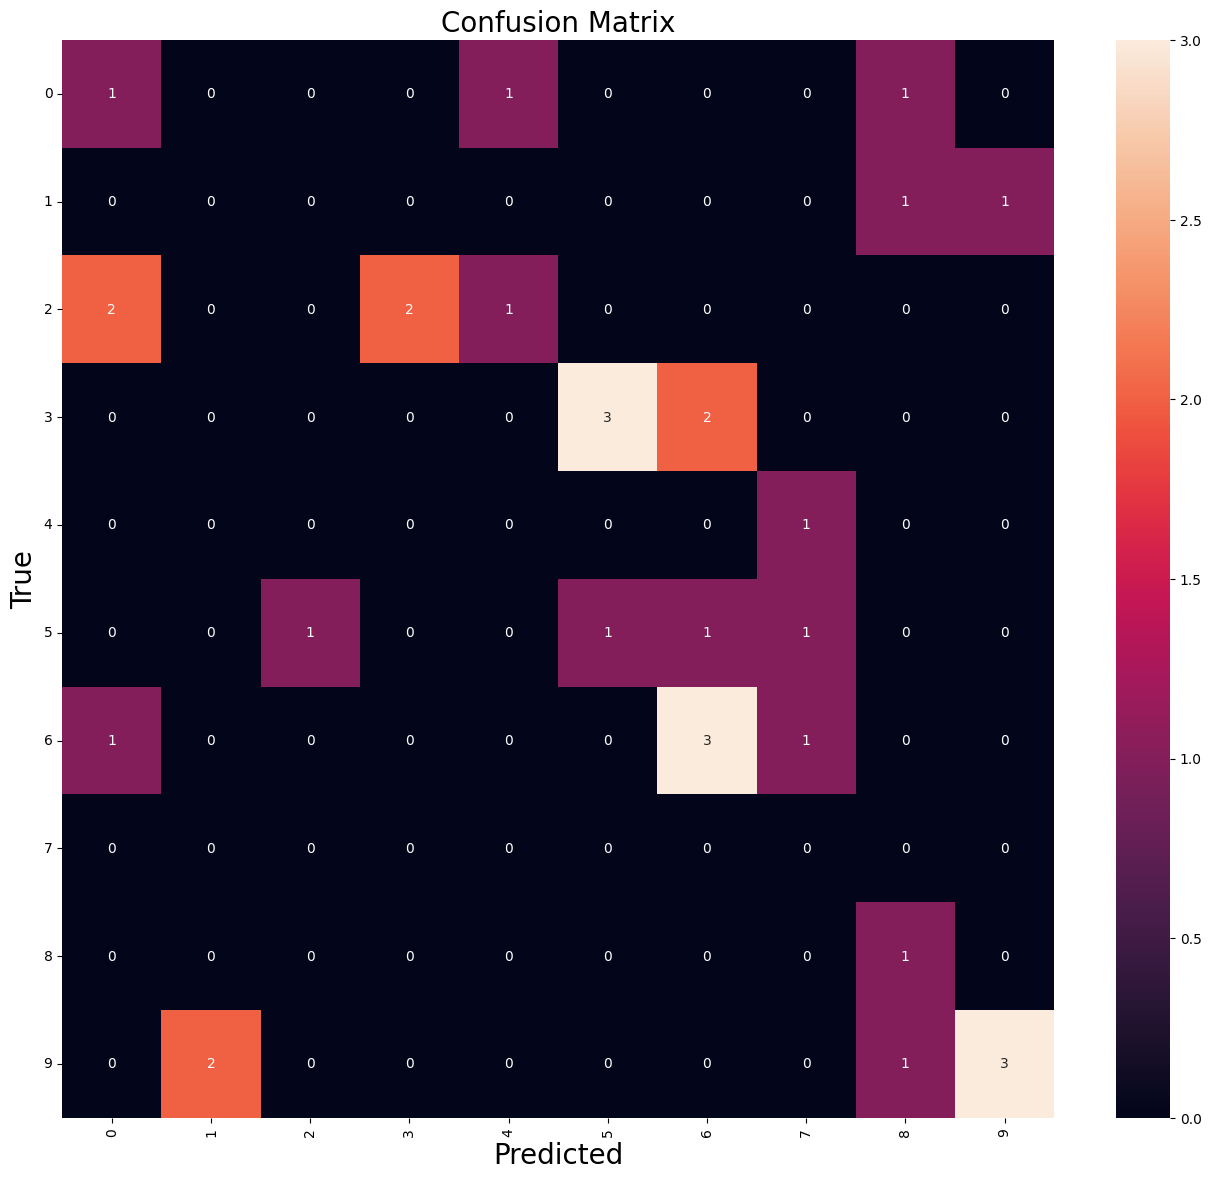

f1_score: 0.20811688311688314


In [18]:
run_attack(model_vit)

Function that helps plot images

Lets use our previously defined function (taken from MITLL) to plot our adversarial images